In [10]:
import os
from itertools import cycle
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, FalsePositives, \
                                    TruePositives, TrueNegatives, FalseNegatives, AUC, Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.utils import plot_model
from sklearn.metrics import plot_roc_curve, precision_recall_curve, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import hiplot as hip

# import plotly.graph_objects as go
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, enable=True) 

In [3]:
class MatthewsCorrelationCoefficient(Metric):
    """
    MCC = (TP * TN) - (FP * FN) /
          ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
    Args:
        num_classes : Number of unique classes in the dataset.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    Usage:
    """
    def __init__(self,thresholds=None, top_k=None, class_id=None, name=None, dtype=None):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.7 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self._thresholds_distributed_evenly = (
            metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.true_negatives = self.add_weight(
            'true_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives,
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            thresholds_distributed_evenly=self._thresholds_distributed_evenly,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        """
        MCC = (TP * TN) - (FP * FN) /
            ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
        """
        A = tf.math.subtract(
            tf.math.multiply(self.true_positives, self.true_negatives),
            tf.math.multiply(self.false_positives, self.false_negatives)) # (TP * TN) - (FP * FN)

        B = tf.math.multiply(tf.math.add(self.true_positives, self.false_positives),
                            tf.math.add(self.true_positives, self.false_negatives)) # (TP + FP) * (TP + FN)
        C = tf.math.multiply(tf.math.add(self.true_negatives, self.false_positives),
                            tf.math.add(self.true_negatives, self.false_negatives)) # (TN + FP ) * (TN + FN)

        D = tf.math.sqrt(tf.math.multiply(B, C))


        result = tf.math.divide_no_nan(A, D)

        return result[0] if len(self.thresholds) == 1 else result

    def reset_state(self):
        num_thresholds = len(to_list(self.thresholds))
        backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                                 for v in (self.true_positives,
                                           self.false_positives,
                                           self.true_negatives,
                                           self.false_negatives)])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(MatthewsCorrelationCoefficient, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
def loadCompileModel(model_dir: str):
    model = tf.keras.models.load_model(model_dir, compile=False)
    return model

In [5]:
def loadTestData(directory: str):
    data_generator = ImageDataGenerator(rescale=1./255)    
    test_data = data_generator.flow_from_directory(
        directory,
        target_size=(96,96),
        color_mode='grayscale',
        classes=['human-false', 'human-true'],
        class_mode='binary',
        batch_size=128,
        shuffle=False,
        seed=19980603
    )
    return test_data

In [6]:
def testModel(folder: str):
    metrics_map = {}
    
    model_name = folder.split('/')[-1]
    if model_name != 'ZoonosisData':
        model_name = model_name.strip('ZoonosisData')
    model = loadCompileModel(folder)
    test = loadTestData(os.path.join(folder, 'test'))
    
    predictions = model.predict(test)
    _, accuracy, _, _ = model.evaluate(test)
    
    precision, recall, _ = precision_recall_curve(test.classes, predictions)
    FP, TP, _ = roc_curve(test.classes, predictions)
    auc = roc_auc_score
    f1 = f1_score
    mcc = matthews_corrcoef
    cm = confusion_matrix
    
    metrics_map = {
        'name':model_name,
        'Accuracy':accuracy,
        'f1_score':f1,
        'AUC':auc,
        'MCC':mcc,
        'PR_curve':(precision, recall),
        'ROC_curve':(FP, TP),
        'Conf_Matrix':cm,
    }
    
    return metrics_map

In [7]:
test_dirs = ['../data/MetazoaZoonosisData/', '../data/ZoonosisData/',
             '../data/RNA-MetazoaZoonosisData/', '../data/DNA-MetazoaZoonosisData/',
             '../data/Plant-HumanZoonosisData/', '../data/NonEukaryote-HumanData/']

In [8]:
model = loadCompileModel('model')

In [9]:
thresh = 0.8

recall = Recall(name = "Recall", thresholds=thresh)
precision = Precision(name = "Precision", thresholds=thresh)
accuracy = BinaryAccuracy(threshold=thresh)
false_positives = FalsePositives(name="FP",thresholds=thresh)
true_positives = TruePositives(name="TP", thresholds=thresh)
true_negatives = TrueNegatives(name="TN", thresholds=thresh)
false_negatives = FalseNegatives(name="FN", thresholds=thresh)
methewsCC = MatthewsCorrelationCoefficient(name="MCC", thresholds=thresh)
auc_roc = AUC(name='AUC')

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    metrics=[
        accuracy,
        recall,
        precision,
        false_positives,
        true_positives,
        true_negatives,
        false_negatives,
        methewsCC,
        auc_roc
    ])

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 48)        13872     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 48)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 48)       

In [12]:
import pydot

ModuleNotFoundError: No module named 'pydot'

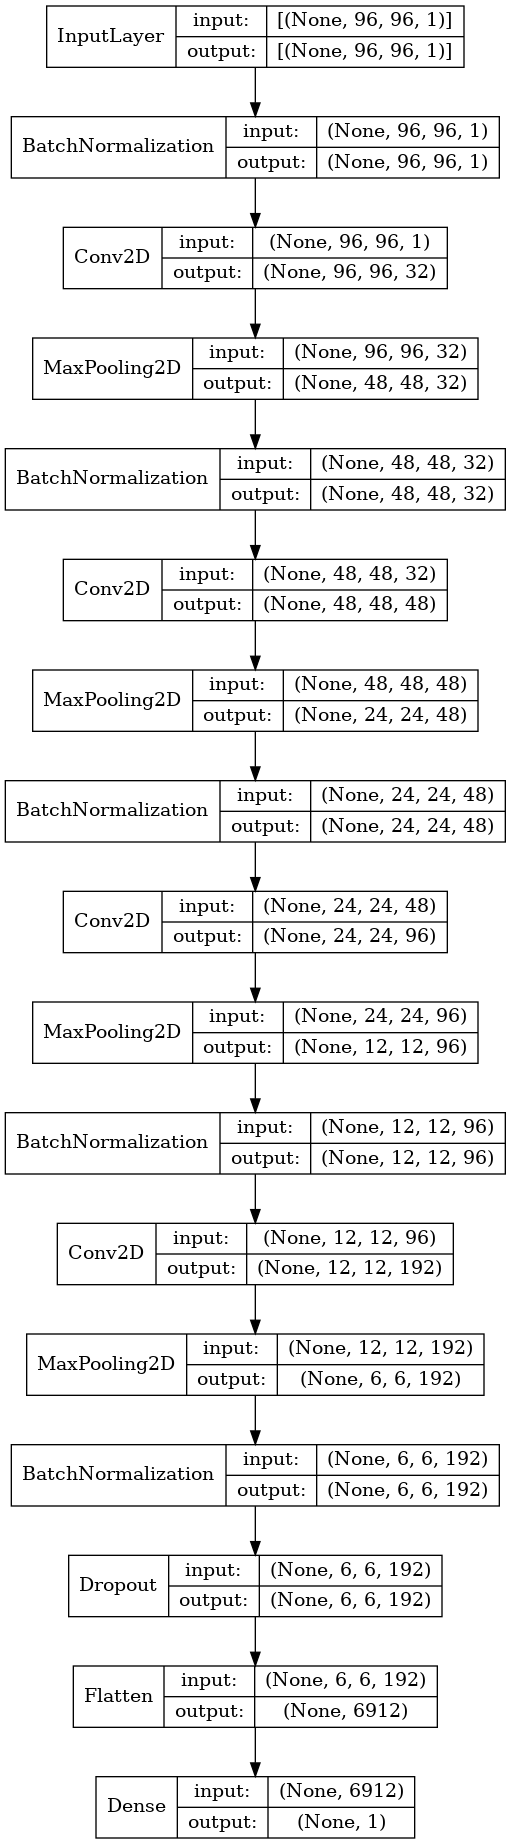

In [19]:
dot_img_file = "model_1.png"
plot_model(model, to_file=dot_img_file, show_layer_names=False, show_shapes=True)

In [22]:
# data = [{
#     'epoch': idx,
#     'loss': history.history['loss'][idx],
#     'val_loss': history.history['val_loss'][idx],
#     'accuracy': history.history['accuracy'][idx],
#     'val_accuracy': history.history['val_accuracy'][idx],
#     'precision': history.history['precision'][idx],
#     'val_precision': history.history['val_precision'][idx],
#     'recall': history.history['recall'][idx],
#     'val_recall': history.history['val_recall'][idx]
# } 
#     for idx in range(0, 10)] 
df = pd.read_csv('logs.csv')
data = df.to_dict('records')

hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

In [168]:
test_data_iterator = loadTestData('/scratch3/users/rserage/ZoonosisData/test/')

Found 20548 images belonging to 2 classes.


In [23]:
evals = model.evaluate(test_data_iterator, return_dict=True)#, steps=90)

90/90 [==============================] - 317s 3s/step - loss: 0.0839 - binary_accuracy: 0.9773 - Recall: 0.9634 - Precision: 0.9677 - FP: 122.0000 - TP: 3655.0000 - TN: 7604.0000 - FN: 139.0000 - MCC: 0.9487 - AUC: 0.9963


In [24]:
evals

{'loss': 0.08393992483615875,
 'binary_accuracy': 0.977343738079071,
 'Recall': 0.9633632302284241,
 'Precision': 0.9676992297172546,
 'FP': 122.0,
 'TP': 3655.0,
 'TN': 7604.0,
 'FN': 139.0,
 'MCC': 0.948659360408783,
 'AUC': 0.9962905645370483}

In [25]:
test_data_iterator.reset()

In [26]:
predictions = (model.predict(test_data_iterator, verbose=1) > 0.8).astype(np.float32).reshape((-1,)).tolist()
predictions[:5]

161/161 [==============================] - 244s 2s/step


[0.0, 0.0, 0.0, 0.0, 0.0]

In [27]:
test_data_iterator.reset()

In [28]:
true_values = test_data_iterator.labels.astype(np.float32).reshape((-1,)).tolist()
true_values[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [29]:
test_data_iterator.reset()

In [30]:
names = [name.split('/')[1].rstrip(".jpeg") for name in test_data_iterator.filenames]

In [31]:
print(len(names))
print(len(predictions))
print(len(true_values))

20548
20548
20548


In [32]:
df = pd.DataFrame.from_dict({'Identifier':names, 'True values':true_values, 'Predictions':predictions})

In [33]:
df.sample(10)

,Identifier,True values,Predictions
10737,human_true_A0A1L3IUB7_Hemagglutinin,1.0,1.0
19432,human_true_Q910P0_Capsid,1.0,1.0
15802,human_true_C4RTD3_Hemagglutinin,1.0,1.0
8654,human_true_A0A0E3XXA5_Hemagglutinin,1.0,1.0
1439,human_false_A0A173ADU8_Hexon,0.0,0.0
6240,human_false_M1TEE3_Envelo,0.0,0.0
2453,human_false_A0A2L1K3C5_Genom,0.0,0.0
8393,human_true_A0A0B4ULS8_Hemagglutinin,1.0,1.0
19250,human_true_Q6GWM4_Capsid,1.0,1.0
18280,human_true_K7Y268_Nucleoprotein,1.0,1.0


In [34]:
matt = MatthewsCorrelationCoefficient(thresholds=0.8, name="MCC")
matt.update_state(df['True values'].tolist(), df['Predictions'].tolist())
matt.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9269497>

In [35]:
df['True values'].to_numpy().reshape(-1)

array([0., 0., 0., ..., 1., 1., 1.])

In [64]:
precision, recall, _ = precision_recall_curve(df['True values'], df['Predictions'])
f1 = f1_score(df['True values'], df['Predictions'])
mcc = matthews_corrcoef(df['True values'], df['Predictions'])
fpr, tpr, _ = roc_curve(df['True values'], df['Predictions'])
roc_auc = roc_auc_score(df['True values'], df['Predictions'])

In [61]:
roc_auc

0.03137069493674171

In [38]:
precision

array([0.62400234, 0.99011505, 1.        ])

In [39]:
recall

array([1.        , 0.95304945, 0.        ])

In [47]:
test_data_iterator.reset()

In [43]:
df['True values'].to_numpy().ravel()

array([0., 0., 0., ..., 1., 1., 1.])

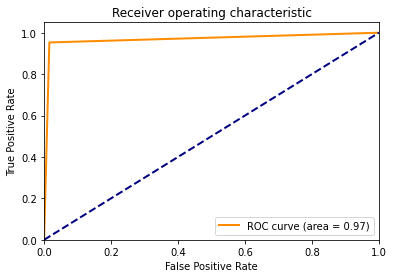

In [65]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [55]:
results_confusion_matrix = confusion_matrix(df['True values'], df['Predictions'])

In [56]:
results_confusion_matrix

array([[ 7604,   122],
       [  602, 12220]])

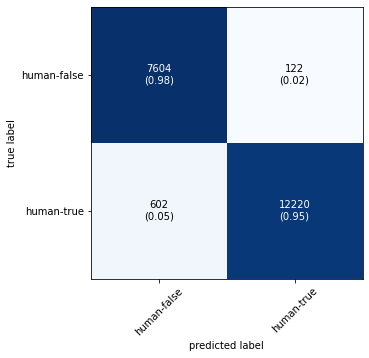

In [58]:
ax = plot_confusion_matrix(
    results_confusion_matrix,figsize=(12,5),
    show_normed=True,
    class_names=['human-false', 'human-true']
)

In [171]:
dir(test_data_iterator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'see

(128, 96, 96, 1)


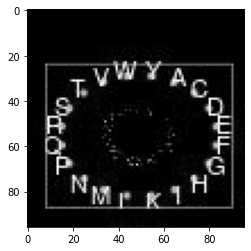

In [200]:
# test_data_iterator.reset()
for _ in range(5):
    img, label = test_data_iterator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0], cmap=plt.cm.binary)
    plt.show()
    print(img[0])
    break

In [31]:
# model = tf.keras.models.load_model('model', custom_objects={"MCC": MatthewsCorrelationCoefficient})
# model.summary()

In [5]:
# img_path = '/scratch3/users/rserage/ZoonosisData/test/human-true/human_true_A0A023HI18_Envelope.jpeg'

img_path = 'testing.png'

img = load_img(img_path, target_size=(300, 300, 1), color_mode='grayscale')
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [6]:
img_tensor.shape

(1, 300, 300, 1)

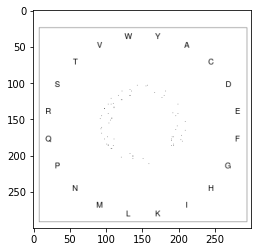

In [7]:
plt.imshow(img_tensor[0], cmap=plt.cm.binary)
# plt.show()

In [8]:
model.input

NameError: name 'model' is not defined

In [34]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [35]:
activations = activation_model.predict(img_tensor)

In [36]:
first_layer_activation = activations[0]

first_layer_activation.shape

(1, 96, 96, 1)

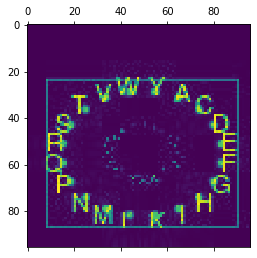

In [37]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
# plt.show()

In [38]:
activations

[array([[[[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]],
 
         [[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]],
 
         [[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]],
 
         ...,
 
         [[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]],
 
         [[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]],
 
         [[-5.524977],
          [-5.524977],
          [-5.524977],
          ...,
          [-5.524977],
          [-5.524977],
          [-5.524977]]]], dtype=float32),
 array([[[[  0.      ,   0.     

/usr/local/lib/python3.6/dist-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/IPython/kernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


MemoryError: Unable to allocate 2.40 TiB for an array with shape (2985984, 110592) and data type float64

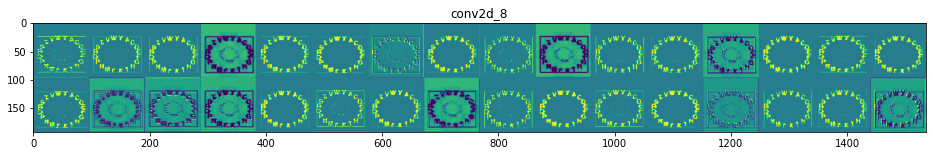

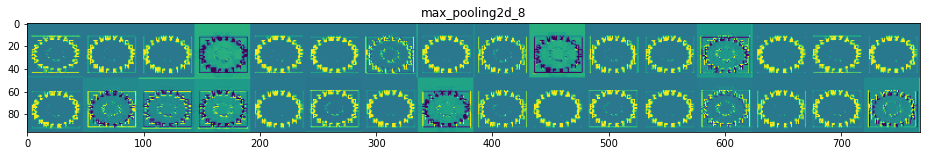

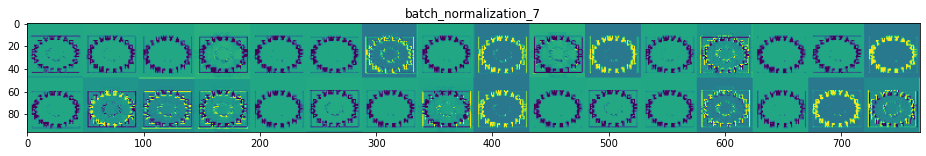

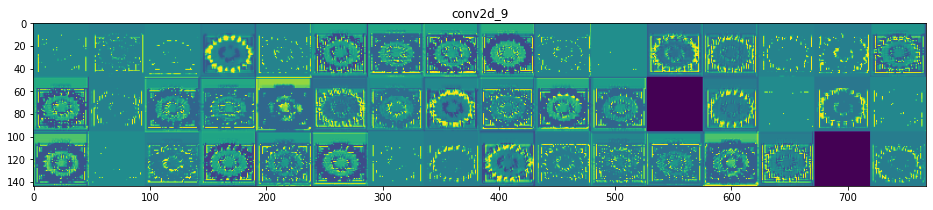

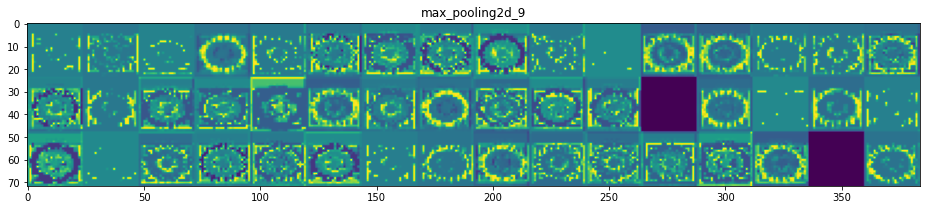

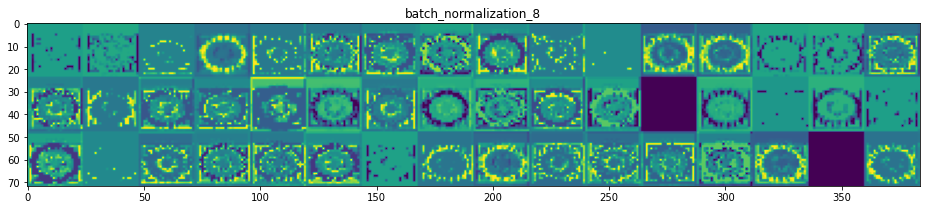

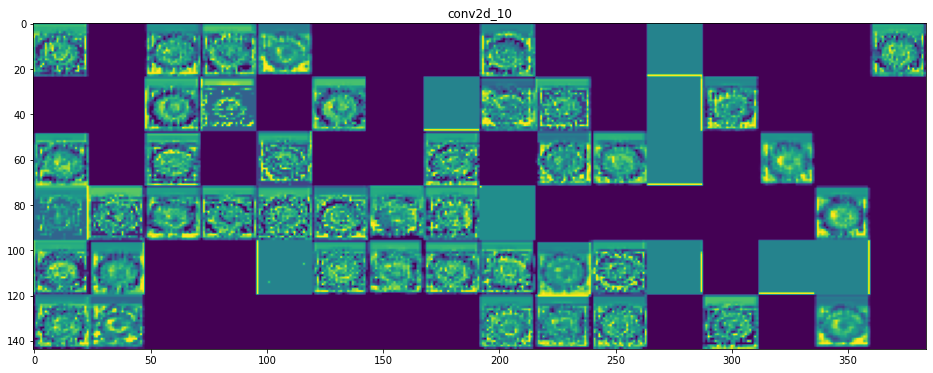

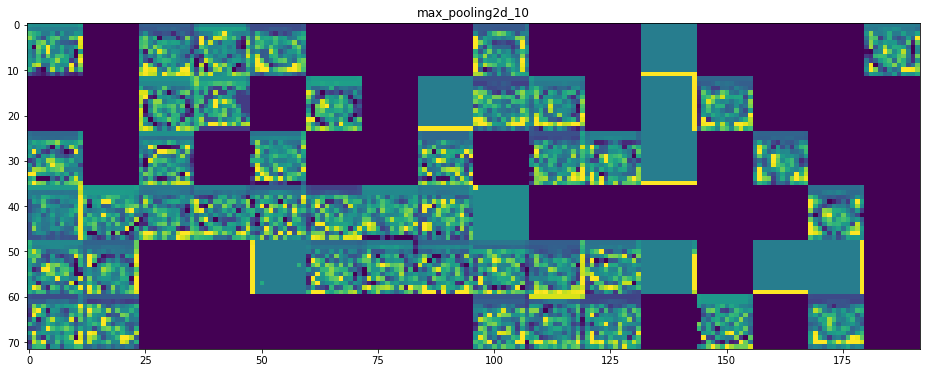

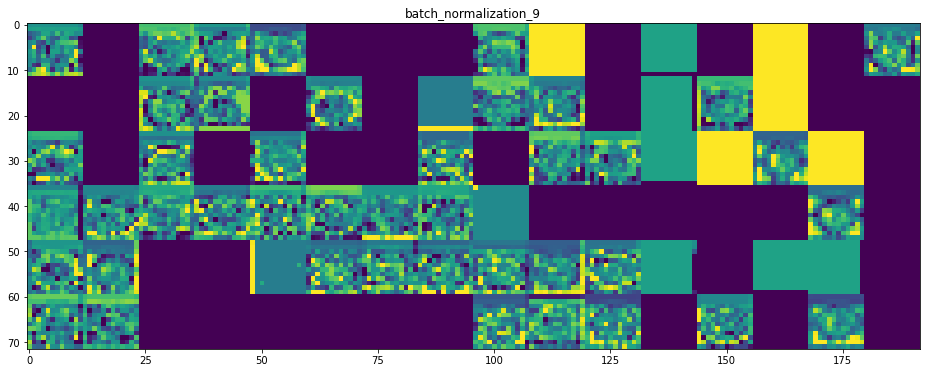

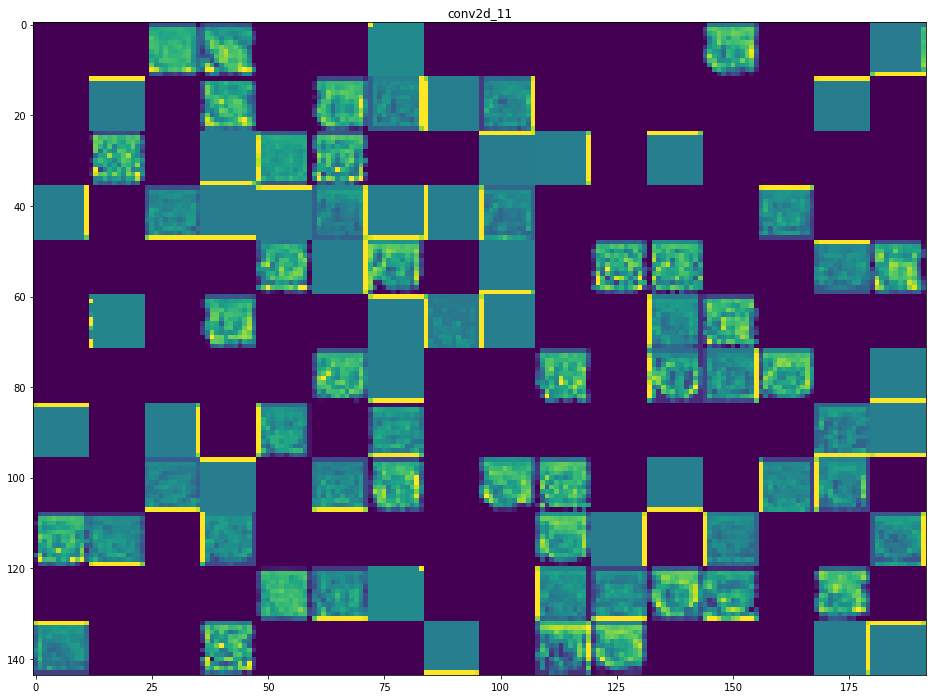

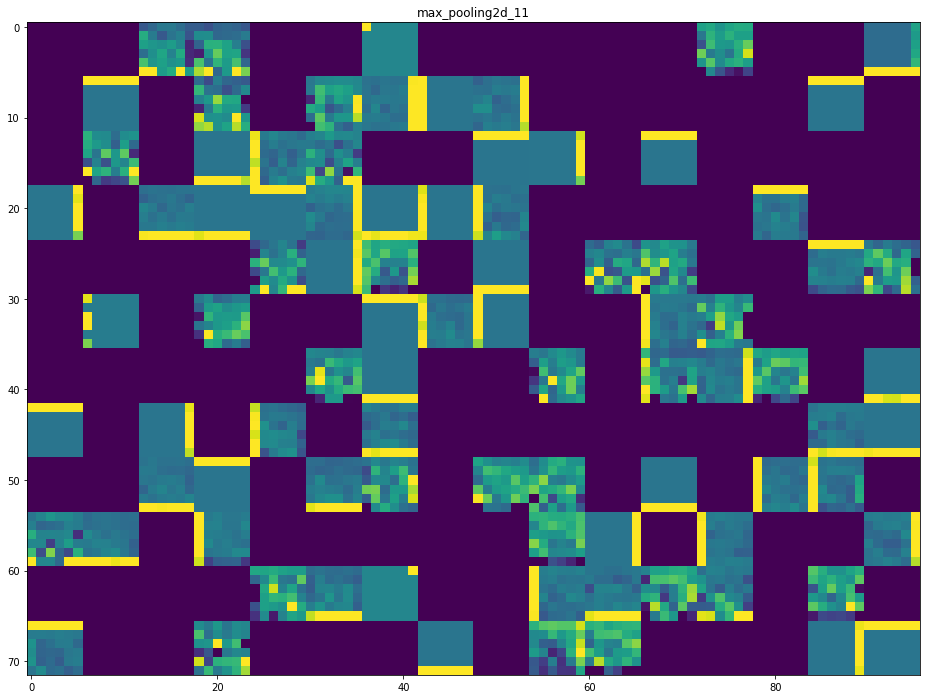

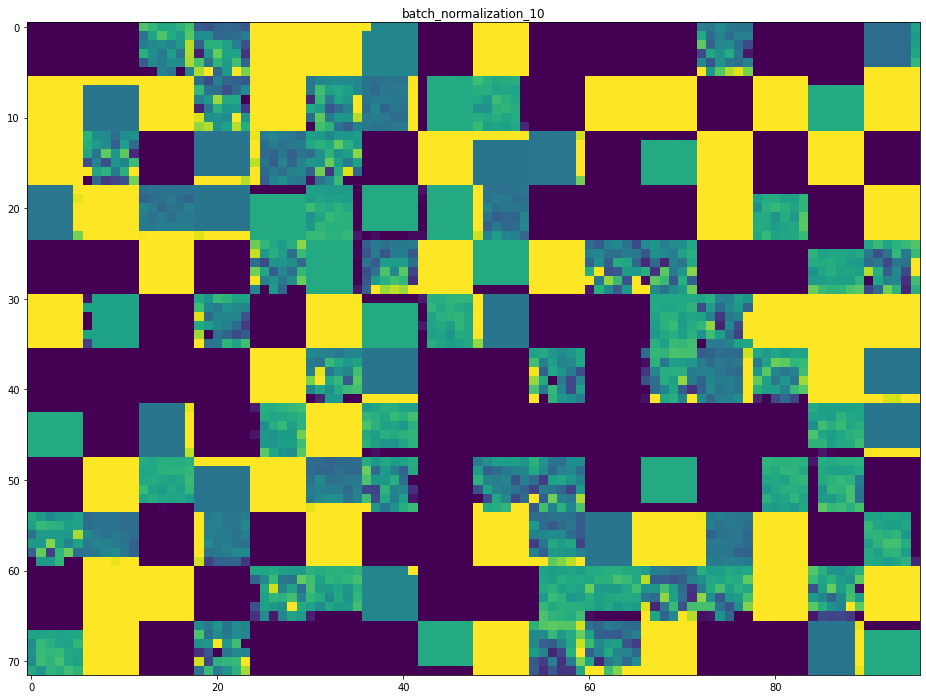

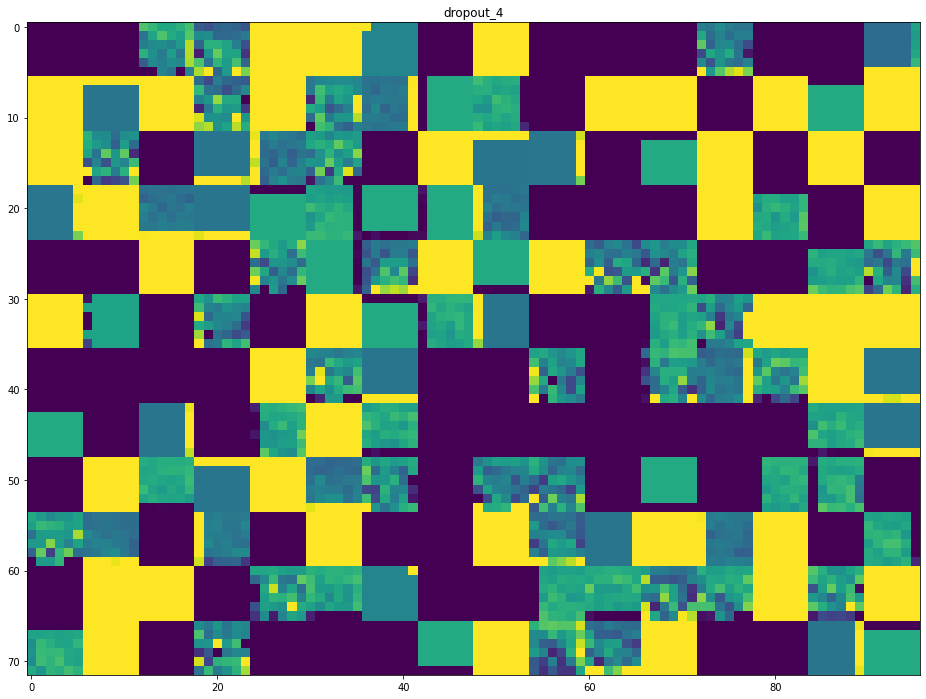

In [39]:
# Names of the layers, so can have them as part of our plot
layer_names = [ layer.name for layer in model.layers[:] ]
    
images_per_row = 16

# Display feature maps
for layer_name, layer_activation in zip(layer_names[1:-1], activations[1:-1]):
    # Number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Tile the activation channels matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tile each filter into horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
# plt.show()

In [118]:
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
# from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [40]:
%reload_ext autoreload
%autoreload 2

from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPU(s)'.format(gpus))

Tensorflow recognized 1 GPUs


In [13]:
import cv2
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency

from tf_keras_vis.scorecam import Scorecam


# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = BinaryScore((1, 0, 1))

replace2linear = ReplaceToLinear()

In [24]:
# Load images and Convert them to a Numpy array
target_size = (300, 300, 1)

image_titles = ['Envelope', 'Spike', 'Hemagglutinin']

# image_as_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/scratch3/users/rserage/ZoonosisData/test/human-true/human_true_A0A023HI18_Envelope.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/scratch3/users/rserage/ZoonosisData/test/human-false/human_false_A0A023PLR7_Spike.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('/scratch3/users/rserage/ZoonosisData/train/human-true/human_true_A0A023J4F7_Hemagglutinin.png', cv2.IMREAD_GRAYSCALE)


# img1 = load_img('/scratch3/users/rserage/ZoonosisData/test/human-true/human_true_A0A023HI18_Envelope.jpeg', target_size=target_size, color_mode='grayscale')
# img2 = load_img('/scratch3/users/rserage/ZoonosisData/test/human-false/human_false_A0A023PLR7_Spike.jpeg', target_size=target_size, color_mode='grayscale')
# img3 = load_img('/scratch3/users/rserage/ZoonosisData/train/human-true/human_true_A0A023J4F7_Hemagglutinin.jpeg', target_size=target_size, color_mode='grayscale')

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
images = images.reshape((3, 300, 300, 1))
def process_img(img):
    # img = cv2.subtract(255, img)
    return img / 255.

X = process_img(images)

In [25]:
images[0].shape

(300, 300, 1)

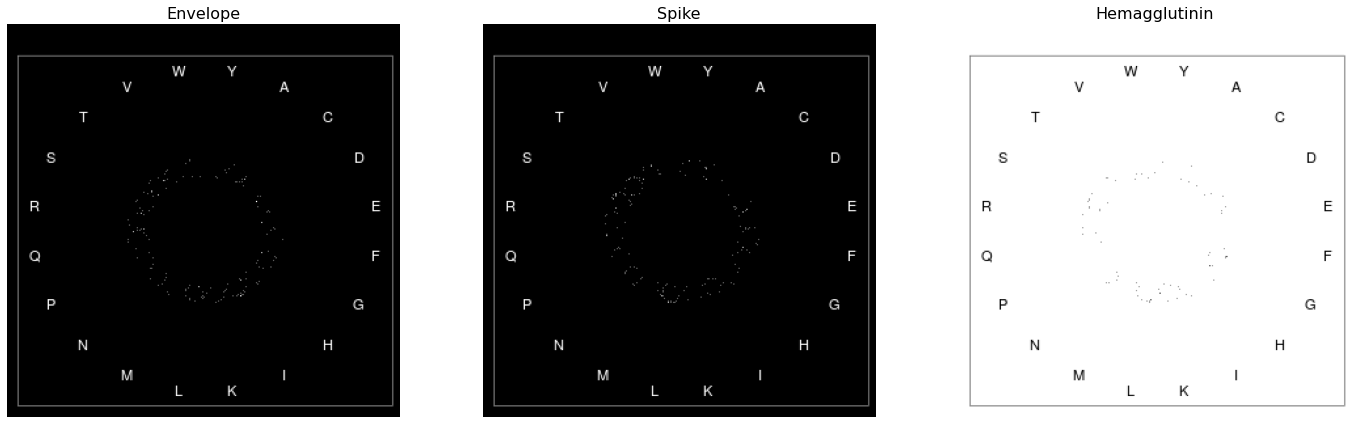

In [26]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i], cmap=plt.cm.binary)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
X.shape

(3, 300, 300, 1)

In [18]:
score.target_values

[True, False, True]

In [157]:

# Create GradCAM++ object
# gradcam = GradcamPlusPlus(model,
#                           model_modifier=replace2linear,
#                           clone=True)

# # Generate heatmap with GradCAM++
# cam = gradcam(score,
#               seed_input=X,
#               penultimate_layer=-1)

# scorecam = Scorecam(model)

# cam = scorecam(score, X, penultimate_layer=-1)

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
# saliency_map = saliency(score, X)
## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

In [149]:
# max(score.indices)

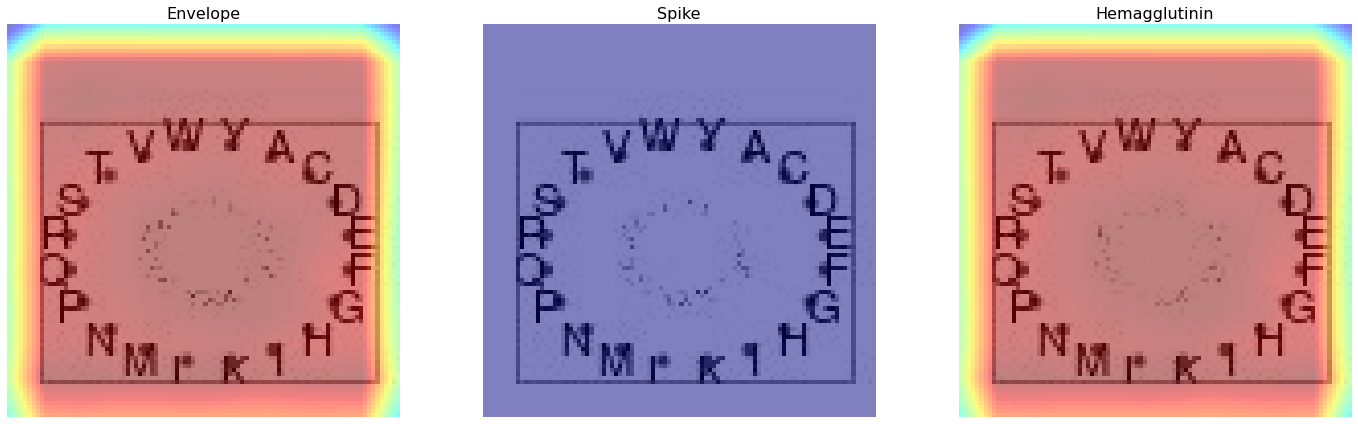

In [165]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i], cmap=plt.cm.binary)
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

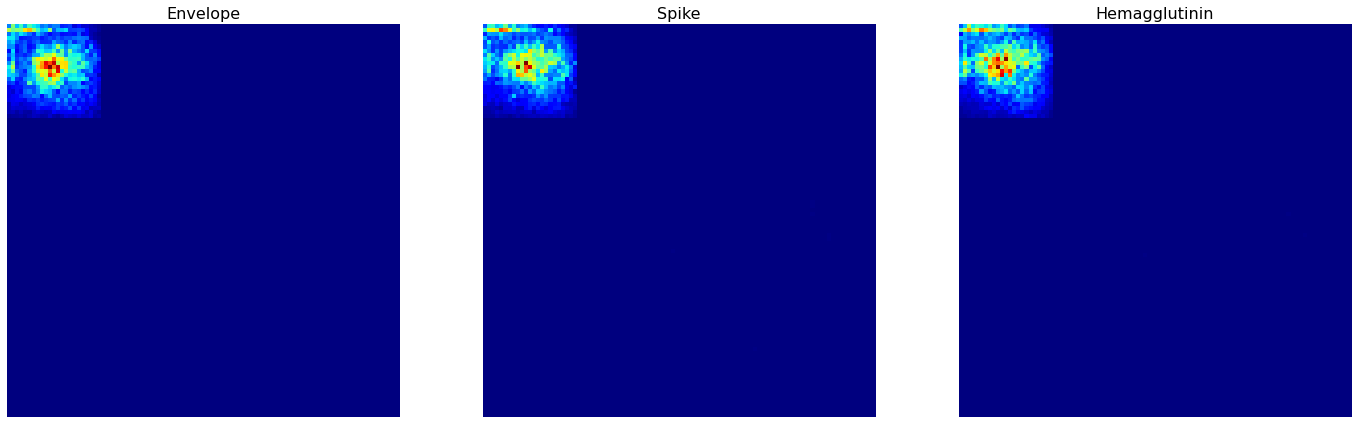

In [164]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [161]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-161-840e219a11f6>, line 2)